# Part 3 - Nuclei Image Segmentation Tutorial

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_3_kaggle_seg.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/thomasjpfan/skorch_talk/blob/master/part_3_kaggle_seg.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_3_kaggle_seg.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch

     |████████████████████████████████| 102kB 3.2MB/s 


## Getting the Data

1. Follow [Kaggle's installation and configuration documentation](https://github.com/Kaggle/kaggle-api#installation) to download `kaggle.json`.
1. Go to Kaggle's [2018 Data Science Bowl Competition](https://www.kaggle.com/c/data-science-bowl-2018), click on "Late Submission" and accept the terms and conditions to get access to the data.		
1. View `kaggle.json` to obtain your username and key to place in the next cell.

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'PUT_USERNNAME_HERE'
os.environ['KAGGLE_KEY'] = 'PUT_KEY_HERE'

In [3]:
from pathlib import Path
from zipfile import ZipFile
from urllib import request

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# Download zip
zipped_file = data_dir / "stage1_train.zip"
if not zipped_file.exists():
    ! kaggle competitions download -c data-science-bowl-2018 -f stage1_train.zip -p data

# unzip cells
cells_dir = data_dir / "cells"
if not cells_dir.exists():
    cells_dir.mkdir(exist_ok=True)
    with ZipFile(zipped_file, 'r') as zip_f:
        zip_f.extractall(cells_dir)
        
        
# download predefined splits
train_valid_json = data_dir / "train_valid_split.json"
if not train_valid_json.exists():
    url = "https://raw.githubusercontent.com/thomasjpfan/skorch_talk/master/data/train_valid_split.json"
    data = request.urlopen(url, timeout=15).read()
    with open(train_valid_json, 'wb') as f:
        f.write(data)

 72% 57.0M/79.1M [00:00<00:00, 53.0MB/s]
100% 79.1M/79.1M [00:00<00:00, 125MB/s] 


Each sample contains one mask per cell. The following combines the masks into one file, creating one mask per sample.

In [4]:
from multiprocessing import Pool		
from pathlib import Path		
from contextlib import ExitStack		

from tqdm import tqdm		
from PIL import Image		

 
def combine_masks(mask_root_dir):		
    mask_output_fn = mask_root_dir / 'mask.png'		
    if mask_output_fn.exists():		
        return		
    mask_fn_iter = mask_root_dir.glob('masks/*.png')		
    img = Image.open(next(mask_fn_iter))		
    for fn in mask_fn_iter:		
        mask = Image.open(fn)		
        img.paste(mask, (0, 0), mask)		
    img.save(mask_output_fn)		


# Combine masks into one		
samples_dirs = list(d for d in Path('data/cells').iterdir() if d.is_dir())		
with ExitStack() as stack:		
    pool = stack.enter_context(Pool())		
    pbar = stack.enter_context(tqdm(total=len(samples_dirs)))		
    for _ in tqdm(pool.imap_unordered(combine_masks, samples_dirs)):		
        pbar.update()

100%|█████████▉| 668/670 [00:25<00:00, 19.61it/s]
668it [00:25, 19.58it/s]
100%|██████████| 670/670 [00:26<00:00, 25.66it/s]


## Utilities

In [0]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn.functional import binary_cross_entropy_with_logits
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from torchvision import models
from itertools import zip_longest, product, chain
import random
from torch.utils.data import Dataset
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                              hflip, vflip, crop)
from PIL import Image
import json


def calcuate_bboxes(im_shape, patch_size):
    """Calculate bound boxes based on image shape and size of the bounding box
    given by `patch_size`"""
    h, w = im_shape
    ph, pw = patch_size

    steps_h = chain(range(0, h - ph, ph), [h - ph])
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class PatchedDataset(Dataset):
    """Creates patches of cells.

    Parameters
    ----------
    base_dataset: CellsDataset
        Dataset of cells
    patch_size: tuple of ints (default=(256, 256))
        The size of each patch
    random_flips: bool (default=False)
        If true, patches and masks will be randomly flipped horizontally and
        vertically.
    padding: int (default=16)
        Amount of paddding around each image and mask
    """
    def __init__(self,
                 base_dataset,
                 patch_size=(256, 256),
                 random_flips=False,
                 padding=16):
        super().__init__()
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)
        self.padding = padding
        self.random_flips = random_flips

        coords = []
        for idx, (_, mask) in enumerate(self.base_dataset):
            w, h = mask.size
            bboxes = calcuate_bboxes((h, w), self.patch_size)
            idx_bboxes = list(zip_longest([], bboxes, fillvalue=idx))
            coords.extend(idx_bboxes)
        self.coords = coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img_idx, (i, j) = self.coords[idx]
        cell, mask = self.base_dataset[img_idx]
        h, w = self.patch_size_expanded

        cell = pad(cell, self.padding, padding_mode='reflect')
        mask = pad(mask, self.padding, padding_mode='reflect')

        cell = crop(cell, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        if self.random_flips:
            if random.random() < 0.5:
                cell = hflip(cell)
                mask = hflip(mask)

            if random.random() < 0.5:
                cell = vflip(cell)
                mask = vflip(mask)

        cell = to_tensor(cell)
        mask = torch.as_tensor((np.array(mask) == 255).astype('float32'))

        # mean and std of imagenet
        cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return cell, mask


class CellsDataset(Dataset):
    """Constructs cell dataset"""
    def __init__(self, sample_dirs):
        super().__init__()
        self.sample_dirs = sample_dirs

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        cell_fn = (sample_dir / 'images' / sample_dir.name).with_suffix('.png')
        mask_fn = sample_dir / 'mask.png'

        cell, mask = Image.open(cell_fn).convert('RGB'), Image.open(mask_fn)
        assert cell.size == mask.size
        return cell, mask

def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    """UNet Model inspired by the the original UNet paper

    Parameters
    ----------
    pretrained: bool (default=True)
        Option to use pretrained vgg16_bn based on ImageNet

    References
    ----------

    .. [1] Olaf Ronneberger, Philipp Fischer, Thomas Brox, 2015,
        "U-Net: Convolutional Networks for Biomedical Image Segmentation,".
        "MICCAI" `<https://arxiv.org/abs/1505.04597>`_
    """
    def __init__(self, pretrained=True):
        super().__init__()
        encoder = models.vgg16_bn(pretrained=pretrained).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

def convert_cell_to_img(t, padding=16):
    """Converts pytorch tensor into a Pillow Image. The padding will be removed
    from the resulting image"""
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    mu = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    output = t.mul(std)
    output.add_(mu)
    img = to_pil_image(output)
    w, h = img.size
    return img.crop((padding, padding, w - padding, h - padding))


def plot_mask_cells(mask_cells, padding=16):
    """Plots cells with their true mask, predicted mask.

    Parameters
    ----------
    mask_cells: list of tuples (`true_mask`, `predicted_mask`, `cell`)
    padding: int (default=16)
        Padding around mask to remove.
    """
    fig, axes = plt.subplots(len(mask_cells), 3, figsize=(14, 14))
    for idx, (axes, mask_cell) in enumerate(zip(axes, mask_cells), 1):
        ax1, ax2, ax3 = axes
        true_mask, predicted_mask, cell = mask_cell
        plot_mask_cell(
                true_mask, predicted_mask, cell,
                'Type {}'.format(idx),
                ax1, ax2, ax3,
                padding=padding)
    fig.tight_layout()
    return fig, axes


def plot_mask_cell(true_mask,
                   predicted_mask,
                   cell,
                   suffix,
                   ax1,
                   ax2,
                   ax3,
                   padding=16):
    """Plots a single cell with a its true mask and predicuted mask"""
    for ax in [ax1, ax2, ax3]:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.imshow(true_mask[padding:-padding, padding:-padding], cmap='viridis')
    ax1.set_title('True Mask - {}'.format(suffix), fontsize=16)
    ax2.imshow(
        predicted_mask[padding:-padding, padding:-padding], cmap='viridis')
    ax2.set_title('Predicted Mask - {}'.format(suffix), fontsize=16)
    ax3.imshow(convert_cell_to_img(cell, padding=padding))
    ax3.set_title('Image - {}'.format(suffix), fontsize=16)
    return ax1, ax2, ax3


def plot_masks(mask_1, mask_2, mask_3):
    """Plots three masks"""
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 10))
    fig.patch.set_alpha(0)
    for ax in [ax1, ax2, ax3]:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.set_title("Type 1", fontsize=20)
    ax1.imshow(mask_1, cmap='viridis')
    ax2.set_title("Type 2", fontsize=20)
    ax2.imshow(mask_2, cmap='viridis')
    ax3.set_title("Type 3", fontsize=20)
    ax3.imshow(mask_3, cmap='viridis')
    return ax1, ax2, ax3


def plot_cells(cell_1, cell_2, cell_3):
    """Plots three cells"""
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 10))
    fig.patch.set_alpha(0)
    for ax in [ax1, ax2, ax3]:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.set_title("Type 1", fontsize=20)
    ax1.imshow(cell_1)
    ax2.set_title("Type 2", fontsize=20)
    ax2.imshow(cell_2)
    ax3.set_title("Type 3", fontsize=20)
    ax3.imshow(cell_3)
    return ax1, ax2, ax3

In [6]:
# Download pretrained model
_ = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:12<00:00, 43639601.97it/s]


## Explore the data

In [0]:
with train_valid_json.open('r') as fp:
    train_valid_split = json.load(fp)

train_dirs = [Path(d) for d in train_valid_split["train_dirs"]]
valid_dirs = [Path(d) for d in train_valid_split["valid_dirs"]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

In [8]:
train_cell_ds[0]

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F76D67684A8>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256 at 0x7F772474C898>)

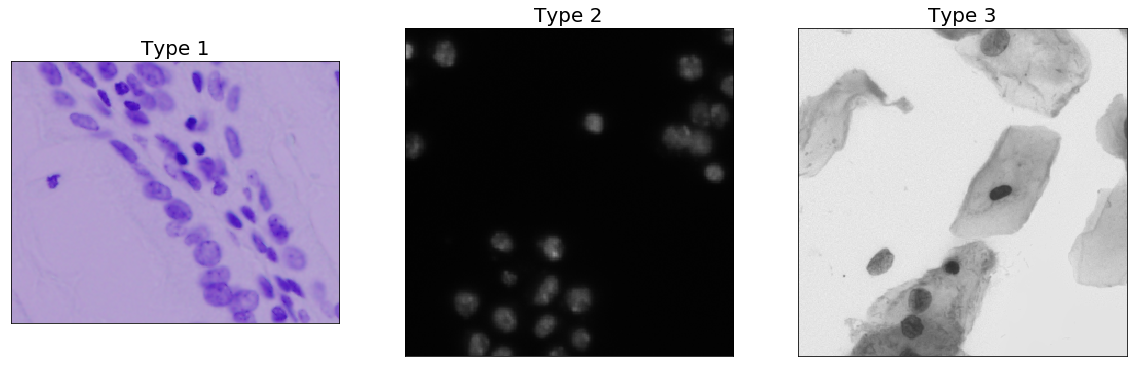

In [9]:
Path('images').mkdir(exist_ok=True)

type1_id, type2_id, type3_id = 13, 6, 25
_ = plot_cells(valid_cell_ds[type1_id][0],
           valid_cell_ds[type2_id][0],
           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))
plt.savefig("images/seg_types.png")

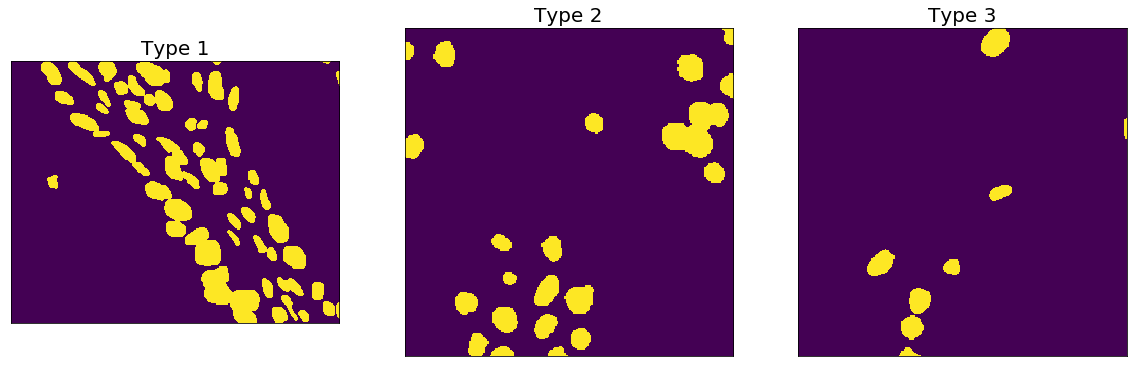

In [10]:
_ = plot_masks(valid_cell_ds[type1_id][1],
               valid_cell_ds[type2_id][1],
               valid_cell_ds[type3_id][1].crop((200, 200, 500, 500)))
plt.savefig("images/seg_type_masks.png")

In [0]:
train_ds = PatchedDataset(
    train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(
    valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

# Padding

In [0]:
from torchvision.transforms.functional import pad

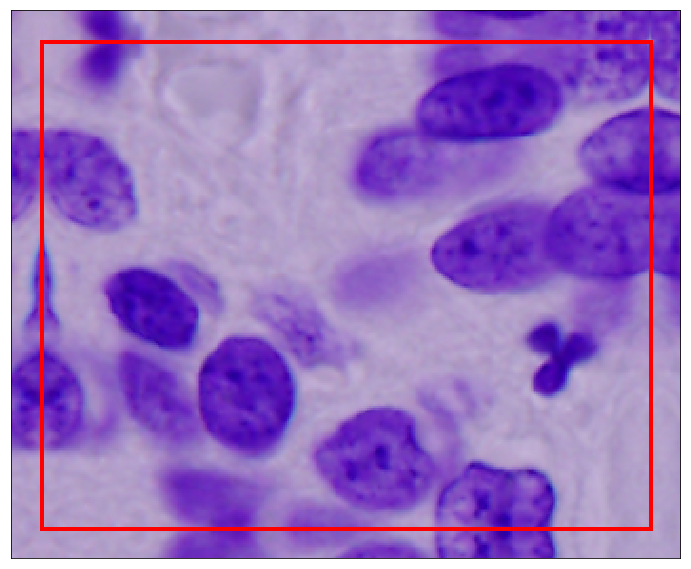

In [13]:
import matplotlib.patches as patches
img = train_cell_ds[3][0]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
rect = patches.Rectangle((16,16),320,256,linewidth=4,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_reflect.jpg")

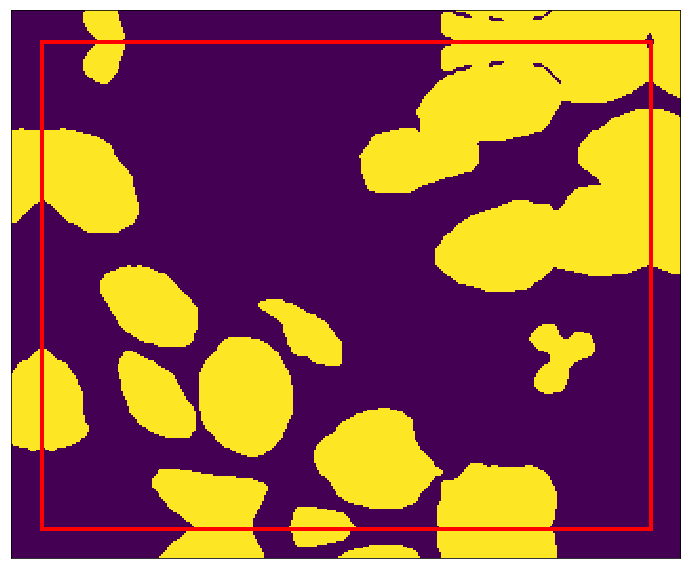

In [14]:
import matplotlib.patches as patches
img = train_cell_ds[3][1]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
rect = patches.Rectangle((16,16),320,256,linewidth=4,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_reflect_mask.jpg")

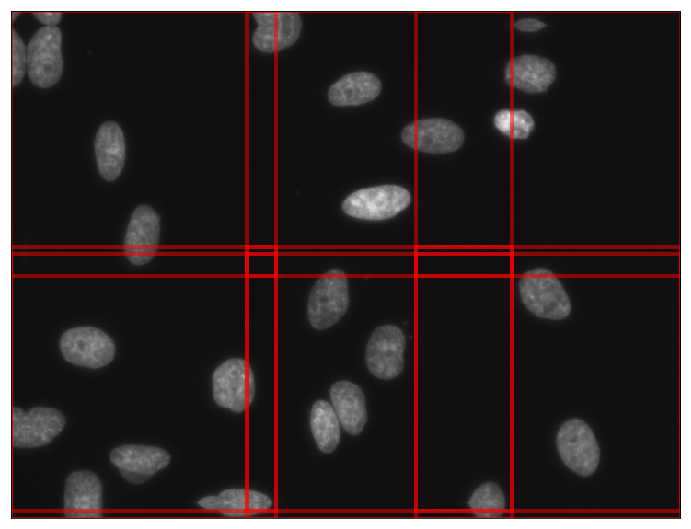

In [15]:
img = train_cell_ds[29][0]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
for box in calcuate_bboxes(img.size, (256, 256)):
    rect = patches.Rectangle(box, 256+32, 256+32, linewidth=4, edgecolor='r', facecolor='none', alpha=0.5)
    ax.add_patch(rect)
_ = ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_patch.jpg")

## Freezer

In [0]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

## Metrics

In [0]:
def approximate_iou_metric(true_masks, predicted_logit_masks, padding=16):
    true_masks = true_masks[:, padding:-padding, padding:-padding]
    predicted_logit_masks = predicted_logit_masks[:, padding:-padding, padding:-padding]
    predicted_masks = 1/(1+np.exp(-predicted_logit_masks))
    
    approx_intersect = np.sum(np.minimum(predicted_masks, true_masks), axis=(1,2))
    approx_union = np.sum(np.maximum(predicted_masks, true_masks), axis=(1,2))
    return np.mean(approx_intersect/approx_union)

In [0]:
from skorch.callbacks import EpochScoring
from sklearn.metrics import make_scorer

iou_scoring = make_scorer(approximate_iou_metric)
iou_scoring = EpochScoring(iou_scoring, name='valid_iou', lower_is_better=False)

## LR Scheduler

In [0]:
from skorch.callbacks import LRScheduler

cyclicLR = LRScheduler(
    policy="CyclicLR", 
    base_lr=0.002, 
    max_lr=0.2,
    step_size_up=550,
    step_size_down=550)

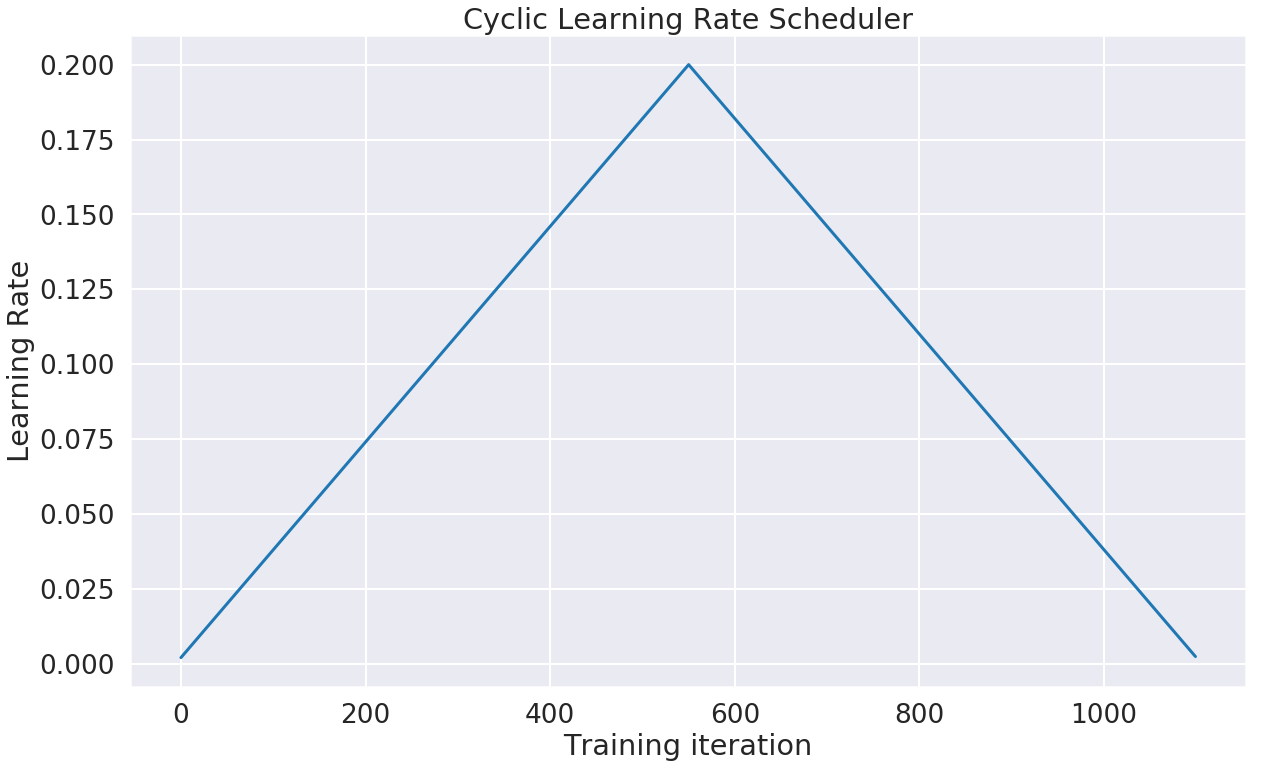

In [20]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster', font_scale=1.2)

fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_alpha(0)
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
_ = ax.plot(cyclicLR.simulate(1100, 0.002))
fig.savefig("images/cyclic_lr.png")

## Custom Loss

In [0]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)

## Checkpoint

In [0]:
from skorch.callbacks import Checkpoint
best_cp = Checkpoint(dirname="kaggle_seg_exp01", monitor="valid_iou_best")

In [0]:
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    UNet,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=16,
    batch_size=32,
    max_epochs=20,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               iou_scoring,
               best_cp],
    device='cuda',
)

In [27]:
_ = net.fit(train_ds)

  epoch    train_loss    valid_iou    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.4945       0.0828        0.4139     +  92.1657
      2        0.3811       0.1431        0.3385     +  92.4948
      3        0.2721       0.3787        0.1978     +  93.5249
      4        0.1363       0.6024        0.1331     +  93.6624
      5        0.0995       0.6986        0.0705     +  93.6066
      6        0.0710       0.7002        0.0638     +  93.2869
      7        0.0697       0.7142        0.0629     +  93.1468
      8        0.0611       0.7490        0.0543     +  93.2434
      9        0.0586       0.7346        0.0542        92.8695
     10        0.0580       0.7570        0.0512     +  92.8068
     11        0.0563       0.7584        0.0528     +  93.3020
     12        0.0553       0.7671        0.0520     +  92.5905
     13        0.0508       0.7677        0.0514     +  92.9643
     14        0.0539       0.7271      

In [28]:
net.initialize()
net.load_params(checkpoint=best_cp)

Re-initializing module.
Re-initializing optimizer because the following parameters were re-set: momentum.


In [0]:
def sigmod(x):
    return 1/(1+np.exp(-x))

In [0]:
val_masks = net.predict(val_ds)

In [0]:
val_prob_masks = sigmod(val_masks.squeeze(1))

In [33]:
print(val_prob_masks.shape)

(468, 288, 288)


## Predictions

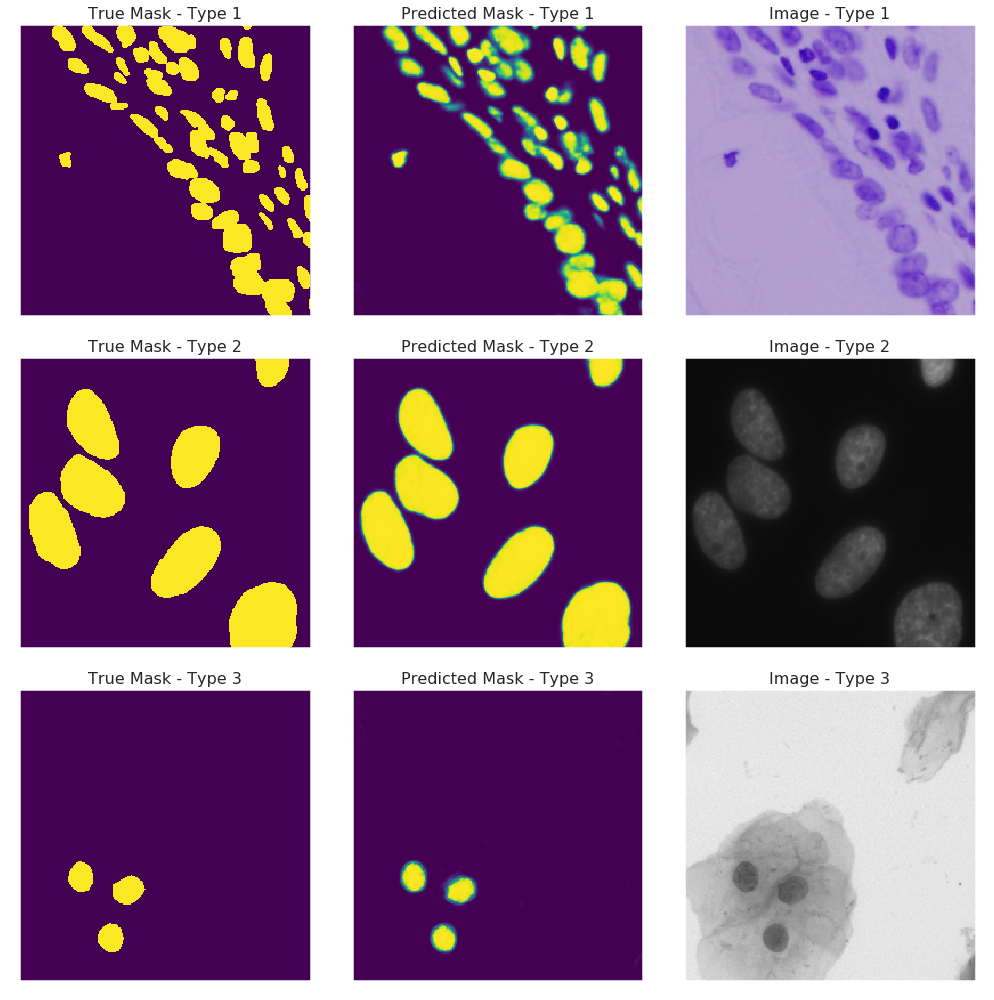

In [34]:
mask_cells = []
for case_id in [45, 8, 81]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)
plt.savefig("images/prediction_seg.jpg")